In [ ]:
import torch
from pnpflow.utils import load_cfg_from_cfg_file
from pnpflow.utils import define_model, load_model
from main import DataLoaders

/home/pourya/miniconda3/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/home/pourya/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = load_cfg_from_cfg_file('./' + 'config/main_config.yaml')
dataset = 'afhq_cat'
method = 'ot'

dataset_config = cfg.root + \
    'config/dataset_config/{}.yaml'.format(
        dataset)
cfg.update(load_cfg_from_cfg_file(dataset_config))

method_config_file = cfg.root + \
    'config/method_config/{}.yaml'.format(
        cfg.method)
cfg.update(load_cfg_from_cfg_file(method_config_file))

# for all keys in the method config file, create a dictionary {key: value} in the cfg object cfg.dict_cfg_method
method_cfg = load_cfg_from_cfg_file(method_config_file)
cfg.dict_cfg_method = {}
for key in method_cfg.keys():
    cfg.dict_cfg_method[key] = cfg[key]

In [3]:
device = "cuda:2"
cfg.device = device
print(cfg)
(model, state) = define_model(cfg)

alpha: 1.0
batch_size_ip: 4
batch_size_train: 16
compute_lipschitz: False
compute_memory: False
compute_metrics: False
compute_time: False
dataset: afhq_cat
device: cuda:2
dict_cfg_method: {'steps_pnp': 100, 'lr_pnp': 1.0, 'gamma_style': 'alpha_1_minus_t', 'num_samples': 5, 'alpha': 1.0}
dim_image: 256
eval: True
eval_split: test
finetune: False
gamma_style: alpha_1_minus_t
lipschitz_constraint: None
lr: 0.0001
lr_pnp: 1.0
max_batch: 1
method: pnp_flow
model: ot
noise_type: gaussian
num_channels: 3
num_epoch: 100
num_samples: 5
problem: superresolution
root: ./
save_results: True
seed: 0
steps_pnp: 100
train: False


In [4]:
batch_size_ip = 1
batch_size = 1
data_loaders = DataLoaders(dataset, batch_size, batch_size_ip).load_data()

model_path = 'model/{}/{}/model_final.pt'.format(dataset, 'ot')
load_model('ot', model, state, download=False,
    checkpoint_path=model_path, dataset=None,  device=device)
model.eval()
model = model.to(device)


/home/pourya/PnP-Flow1/pnpflow/utils.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


sparsity level: tensor(0.2990, device='cuda:2')


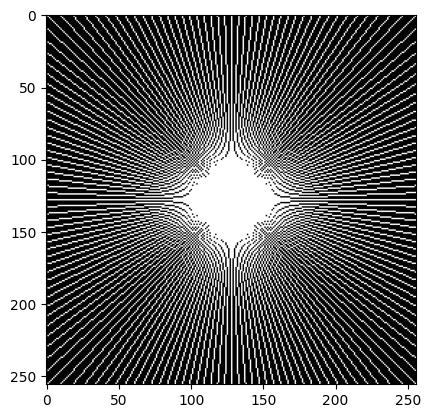

In [10]:
import torch


import scipy
from matplotlib import pyplot as plt
mat = scipy.io.loadmat('radial_mask.mat')
mask = torch.from_numpy(mat['mask']).float().to(device).view([1, 1, 256, 256])
print('sparsity level:', torch.sum(mask) / mask.numel())
plt.imshow(torch.fft.fftshift(mask)[0, 0].cpu(), cmap='gray')   
plt.show()  

def H(x):
    """
    Forward operator: masked 2D FFT.
    """
    # Make sure mask is broadcastable and same type
    k = torch.fft.fft2(x, norm='ortho')
    return k * mask


def Ht(x):
    """
    Adjoint operator: masked inverse 2D FFT.
    For RGB, we do NOT sum over channels.
    """
    y = torch.fft.ifft2(x * mask, norm='ortho')
    # Return real part (MRI is complex, but your RGB image is real)
    return torch.real(y)



In [6]:
# check adjoit 

x = torch.randn(1, 3, 256, 256).double().to(device)
y = torch.randn(1, 3, 256, 256).double().to(device)

Hx = H(x)
HTy = Ht(y)     
inner1 = torch.sum(Hx*y)
inner2 = torch.sum(x*HTy)
print('Inner products: {}, {}'.format(inner1.item(), inner2.item()))    

Inner products: (-164.01403407874244+34.192128062909134j), -164.01403407874233


In [7]:
def model_forward(x, t):
    return model(x, t)


def interpolation_step(x, t):
    return t * x + torch.randn_like(x) * (1 - t)

def denoiser(self, x, t):
    v = self.model_forward(x, t)
    return x + (1 - t.view(-1, 1, 1, 1)) * v


def BtB(x, H, Ht, lam, sigma_noise):    
    BtBD =(Ht(H(x))) / (sigma_noise**2) + x / lam
    return BtBD

def cg(b, x0=None, lam=1, max_iter=100, eps=1e-5, H=lambda x: x, Ht=lambda x: x, dims=(1, 2, 3), sigma_noise=1.0):
    
    A = lambda x: BtB(x, H, Ht, lam, sigma_noise)
    if x0 is None:
        x0 = torch.zeros_like(b, device=b.device, dtype=b.dtype)
    
    x = x0.clone() 
    r = b - A(x)

    p = r.clone()
    r_norm = r_norm_old = (r ** 2).sum(dim=dims, keepdim=True)  

    with torch.no_grad():
        for i in range(max_iter):

            BTBp = A(p)
            alpha = r_norm / ((p * BTBp).sum(dim=dims, keepdim=True))

            x = x + alpha * p
            r_norm_old = r_norm.clone()
            r = r - alpha * BTBp

            r_norm = (r ** 2).sum(dim=dims, keepdim=True) 
            if r_norm.sqrt().all() < eps:
                break
            beta = r_norm / (r_norm_old)
            p = r + beta * p

    return x, i

In [21]:
steps = 100

delta = 1.0 / steps
sigma_noise = 0.01
import numpy as np
for image, i in data_loaders['test']:
    gt = image.to(device)
    y = H(gt) + sigma_noise * torch.randn_like(H(gt), device=device)

    x =  torch.randn_like(gt, device=device)
    ones = torch.ones(len(x), device=device) 
    for count, iteration in enumerate(range(int(steps))):
        print(iteration)
        
        t = delta * iteration    
        
        sigma_r = (1 - t) / np.sqrt(t**2 + (1-t)**2)
        
        x_hat_1 = x + (1 - t) * model_forward(x, ones * t)

        
        lam = sigma_r ** 2
        b = Ht(y) / (sigma_noise**2) + x_hat_1 / lam
        x_star, _ = cg(b, x_hat_1, lam, max_iter=100, eps=1e-5, H=H, Ht=Ht, sigma_noise=sigma_noise)

    
        z0 =  torch.randn_like(x, device=device)
        
        estimated_iso_cov = 1 - t - delta

        x = (t + delta) * x_star + estimated_iso_cov * z0

    break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


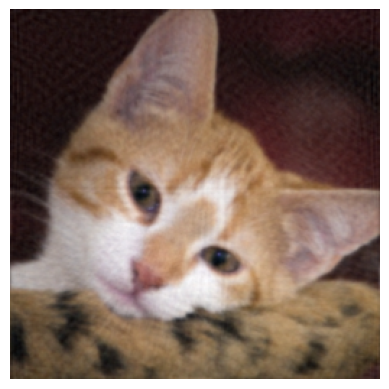

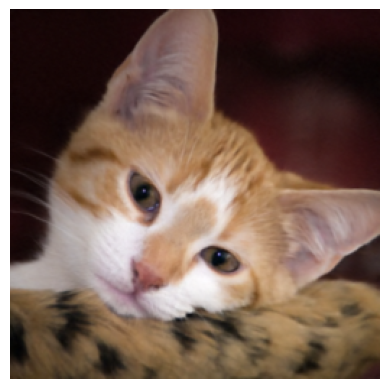

In [22]:
img_tensor = Ht(y).squeeze(0).detach().cpu() 

# normalize to [0, 1] if necessary
img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)

plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis('off')
plt.show()  

img_tensor = x.squeeze(0).detach().cpu()

# normalize to [0, 1] if necessary
img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)

plt.imshow(img_tensor.permute(1, 2, 0))
plt.axis('off')
plt.show()  

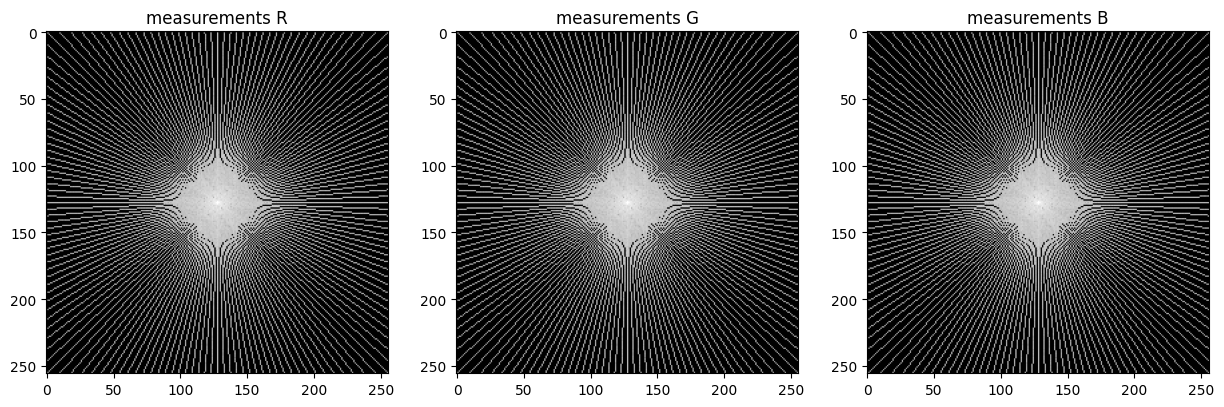

In [27]:
# plot measurement y
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
y = H(gt)
kspace = y[0, 0].detach().cpu()
kspace_magnitude = torch.abs(kspace)
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(y[0, 0, :, :])) +1e-9).cpu().numpy(), cmap='gray')
plt.title('measurements R')

plt.subplot(1, 3, 2)
y = H(gt)
kspace = y[0, 1].detach().cpu()
kspace_magnitude = torch.abs(kspace)
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(y[0, 0, :, :])) +1e-9).cpu().numpy(), cmap='gray')
plt.title('measurements G')

plt.subplot(1, 3, 3)
y = H(gt)
kspace = y[0, 2].detach().cpu()
kspace_magnitude = torch.abs(kspace)
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(y[0, 0, :, :])) +1e-9).cpu().numpy(), cmap='gray')
plt.title('measurements B')
plt.show()    